In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)




In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:
X_train.shape

(64, 48, 48, 1)

In [9]:
y_train.shape

(64, 7)

In [10]:
X_test.shape

(64, 48, 48, 1)

In [11]:
y_test.shape

(64, 7)

In [12]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


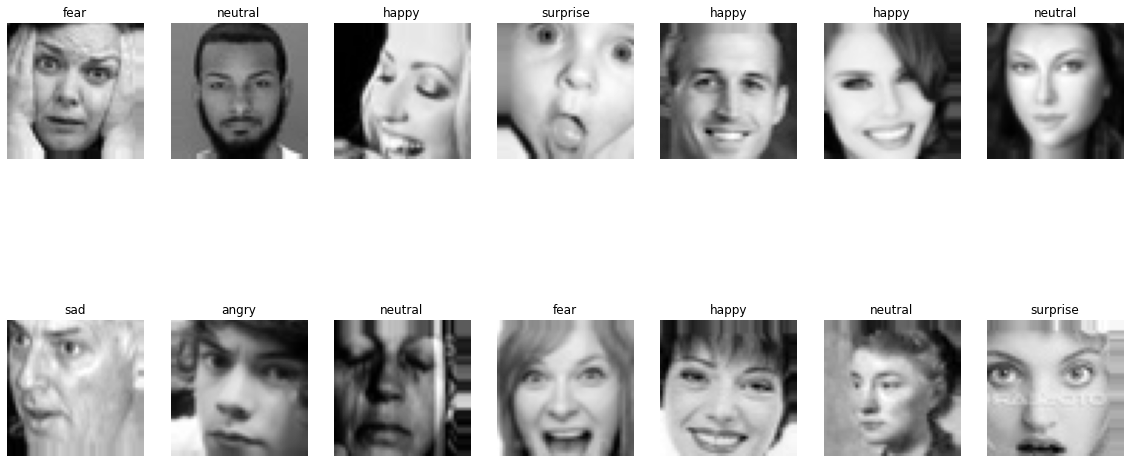

In [13]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [14]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [15]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [16]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [17]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [18]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def model_five(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [20]:
model = model_five(shape = (48, 48, 1), classes = 7)

epochs = 100
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                               

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 7, 7, 128)    0           ['activation_8[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_18 (BatchN  (None, 7, 7, 128)   512         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 7, 7, 128)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 7, 7, 128)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 4, 4, 256)    295168      ['activation_18[0][0]']          
          

 conv2d_29 (Conv2D)             (None, 4, 4, 256)    590080      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_27 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_30[0][0]']              
 ormalizat

                                                                  'activation_34[0][0]']          
                                                                                                  
 activation_36 (Activation)     (None, 4, 4, 256)    0           ['add_17[0][0]']                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_37[0][0]'] 
          

 activation_45 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_45[0][0]']          
                                                                                                  
 batch_normalization_46 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_22 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_46[0][0]', 
                                                                  'dropout_6[0][0]']              
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_55 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_56 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

In [24]:
learning_rate = 0.001
decay_rate = learning_rate / 25
# momentum = 0.8
opt = Adam(lr=learning_rate,  decay=decay_rate)


model.compile(
    optimizer = opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    'fer-43.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [26]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = epochs,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/100
359/359 [==============================] - 127s 319ms/step - loss: 2.3199 - accuracy: 0.1241 - val_loss: 1.9712 - val_accuracy: 0.0154
Epoch 2/100
359/359 [==============================] - 115s 321ms/step - loss: 1.9333 - accuracy: 0.1643 - val_loss: 1.9373 - val_accuracy: 0.0391
Epoch 3/100
359/359 [==============================] - 117s 327ms/step - loss: 1.8944 - accuracy: 0.2138 - val_loss: 1.9421 - val_accuracy: 0.1941
Epoch 4/100
359/359 [==============================] - 118s 328ms/step - loss: 1.8519 - accuracy: 0.2288 - val_loss: 1.8828 - val_accuracy: 0.2849
Epoch 5/100
359/359 [==============================] - 118s 330ms/step - loss: 1.8125 - accuracy: 0.2673 - val_loss: 1.9395 - val_accuracy: 0.2765
Epoch 6/100
359/359 [==============================] - 119s 331ms/step - loss: 1.7839 - accuracy: 0.2749 - val_loss: 1.9117 - val_accuracy: 0.2619
Epoch 7/100
359/359 [==============================] - 119s 331ms/step - loss: 1.7463 - accuracy: 0.3116 - val_loss: 1

359/359 [==============================] - 119s 332ms/step - loss: 0.9895 - accuracy: 0.5894 - val_loss: 1.1338 - val_accuracy: 0.5873
Epoch 57/100
359/359 [==============================] - 120s 332ms/step - loss: 0.9890 - accuracy: 0.5894 - val_loss: 1.3561 - val_accuracy: 0.4763
Epoch 58/100
359/359 [==============================] - 119s 331ms/step - loss: 0.9864 - accuracy: 0.5943 - val_loss: 1.2609 - val_accuracy: 0.5182
Epoch 59/100
359/359 [==============================] - 119s 331ms/step - loss: 0.9871 - accuracy: 0.5987 - val_loss: 1.3784 - val_accuracy: 0.4728
Epoch 60/100
359/359 [==============================] - 119s 331ms/step - loss: 0.9746 - accuracy: 0.5991 - val_loss: 1.1021 - val_accuracy: 0.5936
Epoch 61/100
359/359 [==============================] - 119s 330ms/step - loss: 0.9705 - accuracy: 0.6014 - val_loss: 1.2396 - val_accuracy: 0.5475
Epoch 62/100
359/359 [==============================] - 119s 331ms/step - loss: 0.9623 - accuracy: 0.6006 - val_loss: 1.1730 

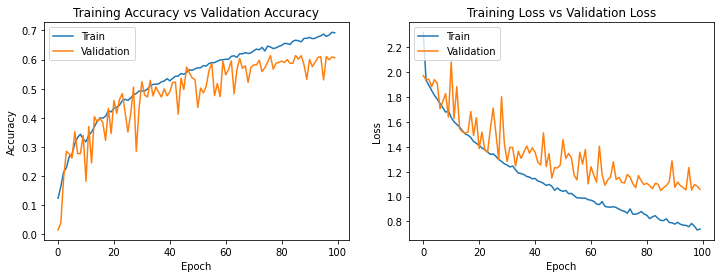

In [27]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [28]:
model.save('deeperdropout43_100_model.h5')
model.save_weights('deeperdropout43_100_weights.h5')

In [29]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 2s 83ms/step - loss: 1.0573 - accuracy: 0.6061
final train accuracy = 70.62 , validation accuracy = 60.61


23/23 [==============================] - 6s 86ms/step
Confusion Matrix
[[32  2 32 42 30 31 22]
 [ 4  0  3  2  7  3  3]
 [31  4 39 41 42 24 23]
 [65  3 63 80 63 41 39]
 [54  7 35 50 37 34 29]
 [48  4 31 67 33 39 27]
 [30  0 25 30 32 30 19]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.17      0.14       191
     disgust       0.00      0.00      0.00        22
        fear       0.17      0.19      0.18       204
       happy       0.26      0.23      0.24       354
     neutral       0.15      0.15      0.15       246
         sad       0.19      0.16      0.17       249
    surprise       0.12      0.11      0.12       166

    accuracy                           0.17      1432
   macro avg       0.14      0.14      0.14      1432
weighted avg       0.18      0.17      0.17      1432



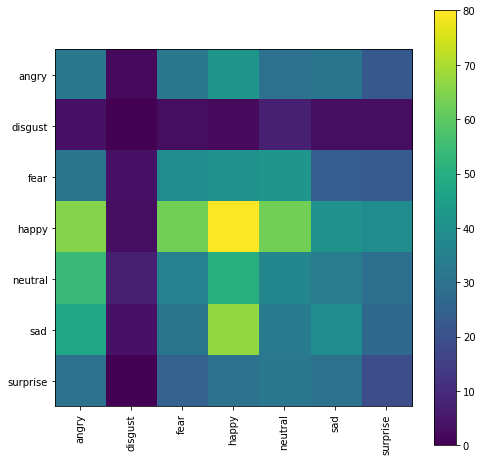

In [30]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 29s 80ms/step
Confusion Matrix
[[ 525   67  484  721  469  550  380]
 [  42   13   54   86   57   64   33]
 [ 517   54  514  760  478  570  385]
 [ 914  105  863 1319  851 1070  650]
 [ 614   72  628  894  563  745  456]
 [ 637   71  618  857  590  652  439]
 [ 365   49  380  612  352  474  305]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.16      0.15      3196
     disgust       0.03      0.04      0.03       349
        fear       0.15      0.16      0.15      3278
       happy       0.25      0.23      0.24      5772
     neutral       0.17      0.14      0.15      3972
         sad       0.16      0.17      0.16      3864
    surprise       0.12      0.12      0.12      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.15      0.14     22968
weighted avg       0.17      0.17      0.17     22968



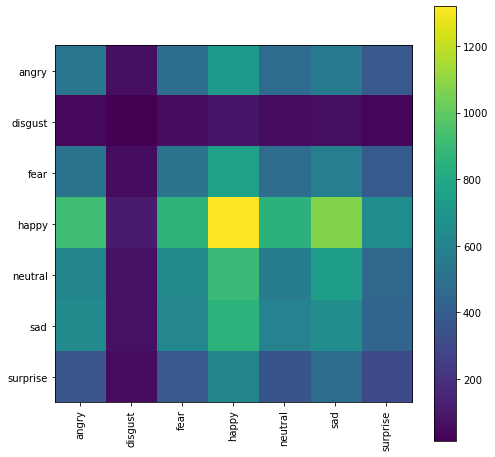

In [31]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)